### aim: 

### date: 

In [79]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [80]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [81]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### dong comes from here:

https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2006JC004051&file=jgrc10600-sup-0002-ds01.txt

In [82]:
get_nc = False
if get_nc:
    df = pd.read_csv('./Dong2008argo.csv')
    # df.columns.tolist()

    new_df = df[['Month', 'latitude','longitude', 'MLDpd']]

    new_df.rename(columns={'Month ': 'mon'}, inplace=True)
    new_df.rename(columns={'latitude ': 'lat'}, inplace=True)
    new_df.rename(columns={'longitude   ': 'lon'}, inplace=True)
    new_df.rename(columns={'MLDpd     ': 'MLDpd'}, inplace=True)


    df2 = new_df

    savenam1 = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam1)
    ds = cdomask.tmask

    mld_stor = np.zeros([12,180,360])

    for m in range(1,13):
        mo_in = m-1
        print(m)
        for lo in range(0,360):
            if lo%60 == 0:
                print(f'---{lo}')
            for la in range(-89,-30,1):

                lo_df = lo+0.5
                la_df = la - 0.5
                w = np.where((ds.lon==lo) & (ds.lat==la_df))
                lon_in = (w[0][0])
                lat_in = (w[1][0])
                # get dataframe loc
                try:
                    tdf = (df2[(df2.Month == m) & (df2.latitude == la_df) & (df2.longitude == lo_df)])
                    MLD = (tdf.MLDpd.values[0])
                    if MLD > 9990:
                        MLD = np.nan
                    #print(f'{lo_df} ({lon_in}), {la_df} ({lat_in}), {MLD}')
                    mld_stor[mo_in,lat_in,lon_in] = MLD
                except:
                    pass

    yr = 2000
    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='MS',closed='left')

    savenam = './Dong2008MLD.nc'
    data_vars = {'MLD':(['time_counter', 'lat', 'lon'], mld_stor,
    {'units': 'm',
    'long_name':'mld southern ocean from JGR Dong 2008, sigma 0.03 crit'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),           
    'lat': (['lat'], ds.lat),
    'lon': (['lon'], ds.lon),
    }

    # define global attributes
    attrs = {'made in':'scratch/SOZONE/windAnalyis/oceanFields/observational_MLD.ipynb',
    'desc': 'dong in a netcdf'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)


In [83]:
w = xr.open_dataset('Dong2008MLD.nc')
w_masked = w.where(w['MLD'] != 0)

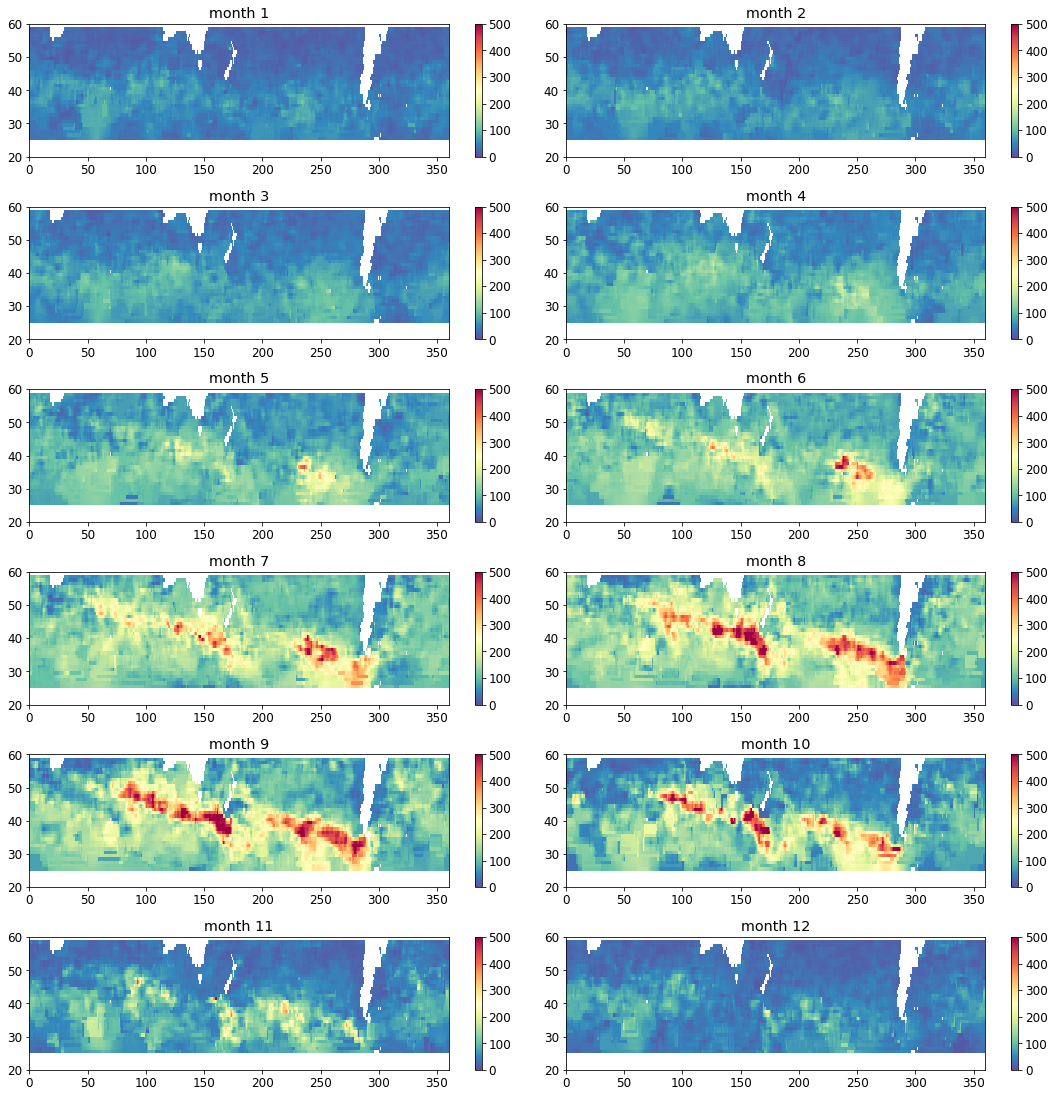

In [84]:


fact = 1.1
fig, axs = plt.subplots(6,2, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,12):
    q = axs[i].pcolormesh(w_masked.MLD[i,:,:], vmin = 0, vmax = 500, cmap = 'Spectral_r')
    axs[i].set_ylim([20,60])
    axs[i].set_title(f'month {i+1}')
    plt.colorbar(q, ax = axs[i])
    
plt.tight_layout()

### now we want to compare UKESM and TOM to DONG

dong has data -64.5 - -29.5 (inclusive)

    - get weighted averages for that tp
    - 



In [123]:
cdomask.lat[25:40]

<xarray.DataArray 'lat' (lat: 15)>
array([-64.5, -63.5, -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5,
       -54.5, -53.5, -52.5, -51.5, -50.5])
Coordinates:
  * lat      (lat) float64 -64.5 -63.5 -62.5 -61.5 ... -53.5 -52.5 -51.5 -50.5

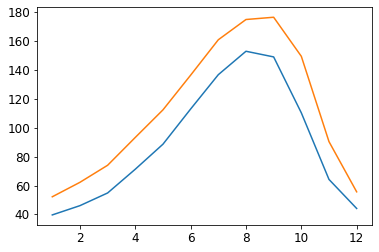

In [124]:
w = xr.open_dataset('Dong2008MLD.nc')

savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
ds = cdomask.tmask

mld_DONG = np.zeros([12])
mld_50DONG = np.zeros([12])
for i in range(0,12):
    MLD = w.MLD[i,:,:].isel(lat=slice(25,60)).values
    weights = (cdomask.tmask.isel(lat=slice(25,60))).values
    MLD[np.where(np.isnan(MLD))] = 0
    weights[np.where(MLD == 0)] = 0
    mld_DONG[i] =(np.average(MLD, weights = weights))

    MLD = w.MLD[i,:,:].isel(lat=slice(25,40)).values
    weights = (cdomask.tmask.isel(lat=slice(25,40))).values
    MLD[np.where(np.isnan(MLD))] = 0
    weights[np.where(MLD == 0)] = 0
    mld_50DONG[i] =(np.average(MLD, weights = weights))
    
mos = np.arange(1,13,1)
plt.figure()
plt.plot(mos, mld_DONG)
plt.plot(mos, mld_50DONG)

In [86]:
def make_yearlist_uk(yrst, yrend, scen):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/'
        t2 = glob.glob(f'{tdir}/nemo_scen_{scen}_1m_{y}_fy_grid-T.nc')
        ylist.append(t2[0])
    return ylist

def make_yearlist_tom(yrst, yrend, scen, dir1 = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = f'{dir1}{scen}/'
        t2 = glob.glob(f'{tdir}/ORCA2_1m_{y}0101_{y}1231_grid_T.nc')
        ylist.append(t2[0])
    return ylist

ukesm_mld = xr.open_mfdataset(make_yearlist_uk(2001, 2007, '1A'))
TJ_1AA6_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_1AA6'))
TJ_RVA0_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_RVA0'))
TJ_1ASA_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_TJ_1ASA'))
ET_SI73_mld = xr.open_mfdataset(make_yearlist_tom(2001, 2007, 'TOM12_ET_SI73', dir1 = '/gpfs/home/e031/scratch/'))

In [87]:
mm_med = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
mm_med['area'] = mm_med.tmask[0,:,:] * mm_med.e1t[:,:] * mm_med.e2t[:,:]

mm_tom = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
mm_tom['area'] = mm_tom.tmask[0,0,:,:] * mm_tom.e1t[0,:,:] * mm_tom.e2t[0,:,:]

In [88]:
#ET_SI73_mld/mldr10_1
#-64.867195 to #-30.455408
ET_SI73_50somxl030 = ET_SI73_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1ASA_50somxl030 = TJ_1ASA_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1AA6_50somxl030 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_RVA0_50somxl030 = TJ_RVA0_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])

ET_SI73_50mldr10_1 = ET_SI73_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1ASA_50mldr10_1 = TJ_1ASA_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1AA6_50mldr10_1 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_RVA0_50mldr10_1 = TJ_RVA0_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])

ukesm_50somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,114)).weighted(mm_med.area.sel(y=slice(85,114))).mean(dim = ['y','x'])

#ET_SI73_mld/mldr10_1
#-64.867195 to #-30.455408
ET_SI73_somxl030 = ET_SI73_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_1ASA_somxl030 = TJ_1ASA_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_1AA6_somxl030 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_RVA0_somxl030 = TJ_RVA0_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])

ET_SI73_mldr10_1 = ET_SI73_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_1ASA_mldr10_1 = TJ_1ASA_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_1AA6_mldr10_1 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_RVA0_mldr10_1 = TJ_RVA0_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])

ukesm_somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,140)).weighted(mm_med.area.sel(y=slice(85,140))).mean(dim = ['y','x'])

ukesm_somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,140)).weighted(mm_med.area.sel(y=slice(85,140))).mean(dim = ['y','x'])

TJ_1AA6_50somxl030 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1AA6_50mldr10_1 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
ukesm_50somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,114)).weighted(mm_med.area.sel(y=slice(85,114))).mean(dim = ['y','x'])

TJ_1AA6_somxl030 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_1AA6_mldr10_1 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
ukesm_somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,140)).weighted(mm_med.area.sel(y=slice(85,140))).mean(dim = ['y','x'])



Text(0.5, 1.0, 'SO mixed layer depth monthly clim (2001-2006), -65 to -30 south \n note that obs use 0.03$\\sigma$ criterion, UKESM only has 0.01$\\sigma$, \n TOM has both, with 0.01 in dotted lines')

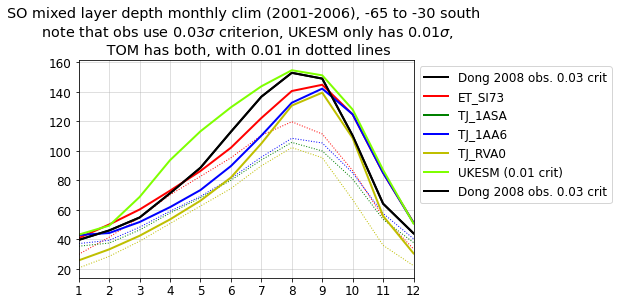

In [89]:
plt.figure()
plt.plot(mos, mld_DONG, color = 'k', linestyle = '-', linewidth = 2, label = 'Dong 2008 obs. 0.03 crit')

tom_030 = [ET_SI73_50somxl030,TJ_1ASA_50somxl030,TJ_1AA6_50somxl030,TJ_RVA0_50somxl030]
tom_010 = [ET_SI73_50mldr10_1,TJ_1ASA_50mldr10_1,TJ_1AA6_50mldr10_1,TJ_RVA0_50mldr10_1]
#labs = [ET_SI73_50mldr10_1,TJ_1ASA_50mldr10_1,TJ_1AA6_50mldr10_1,TJ_RVA0_50mldr10_1]
labs = ['ET_SI73','TJ_1ASA','TJ_1AA6','TJ_RVA0']
cols = ['r','g','b','y']

for i in range(0,4):
    plt.plot(mos, tom_030[i], color = cols[i], linestyle = '-', linewidth = 2, label = labs[i])
    plt.plot(mos, tom_010[i], color = cols[i], linestyle = ':', linewidth = 1)
plt.plot(mos, ukesm_50somxl010, color = 'chartreuse', linestyle = '-', linewidth = 2, label = 'UKESM (0.01 crit)')
plt.plot(mos, mld_DONG, color = 'k', linestyle = '-', linewidth = 2, label = 'Dong 2008 obs. 0.03 crit')

plt.xticks(np.arange(1,13,1))
plt.xlim([1,12])
plt.grid(alpha = 0.5)
plt.legend(bbox_to_anchor = [1,1])

plt.title('SO mixed layer depth monthly clim (2001-2006), -65 to -30 south \n note that obs use 0.03$\sigma$ criterion, UKESM only has 0.01$\sigma$, \n TOM has both, with 0.01 in dotted lines')

Text(0.5, 1.0, 'SO mixed layer depth monthly clim (2001-2006), -65 to -50 south \n note that obs use 0.03$\\sigma$ criterion, UKESM only has 0.01$\\sigma$, \n TOM has both, with 0.01 in dotted lines')

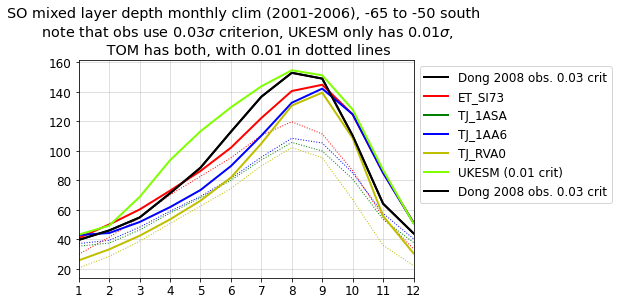

In [90]:
#ET_SI73_mld/mldr10_1
#-64.867195 to #-30.455408
ET_SI73_50somxl030 = ET_SI73_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1ASA_50somxl030 = TJ_1ASA_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1AA6_50somxl030 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_RVA0_50somxl030 = TJ_RVA0_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])

ET_SI73_50mldr10_1 = ET_SI73_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1ASA_50mldr10_1 = TJ_1ASA_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1AA6_50mldr10_1 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_RVA0_50mldr10_1 = TJ_RVA0_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])

ukesm_50somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,114)).weighted(mm_med.area.sel(y=slice(85,114))).mean(dim = ['y','x'])


plt.figure()
plt.plot(mos, mld_DONG, color = 'k', linestyle = '-', linewidth = 2, label = 'Dong 2008 obs. 0.03 crit')

tom_030 = [ET_SI73_50somxl030,TJ_1ASA_50somxl030,TJ_1AA6_50somxl030,TJ_RVA0_50somxl030]
tom_010 = [ET_SI73_50mldr10_1,TJ_1ASA_50mldr10_1,TJ_1AA6_50mldr10_1,TJ_RVA0_50mldr10_1]
#labs = [ET_SI73_50mldr10_1,TJ_1ASA_50mldr10_1,TJ_1AA6_50mldr10_1,TJ_RVA0_50mldr10_1]
labs = ['ET_SI73','TJ_1ASA','TJ_1AA6','TJ_RVA0']
cols = ['r','g','b','y']

for i in range(0,4):
    plt.plot(mos, tom_030[i], color = cols[i], linestyle = '-', linewidth = 2, label = labs[i])
    plt.plot(mos, tom_010[i], color = cols[i], linestyle = ':', linewidth = 1)
plt.plot(mos, ukesm_50somxl010, color = 'chartreuse', linestyle = '-', linewidth = 2, label = 'UKESM (0.01 crit)')
plt.plot(mos, mld_DONG, color = 'k', linestyle = '-', linewidth = 2, label = 'Dong 2008 obs. 0.03 crit')

plt.xticks(np.arange(1,13,1))
plt.xlim([1,12])
plt.grid(alpha = 0.5)
plt.legend(bbox_to_anchor = [1,1])

plt.title('SO mixed layer depth monthly clim (2001-2006), -65 to -50 south \n note that obs use 0.03$\sigma$ criterion, UKESM only has 0.01$\sigma$, \n TOM has both, with 0.01 in dotted lines')



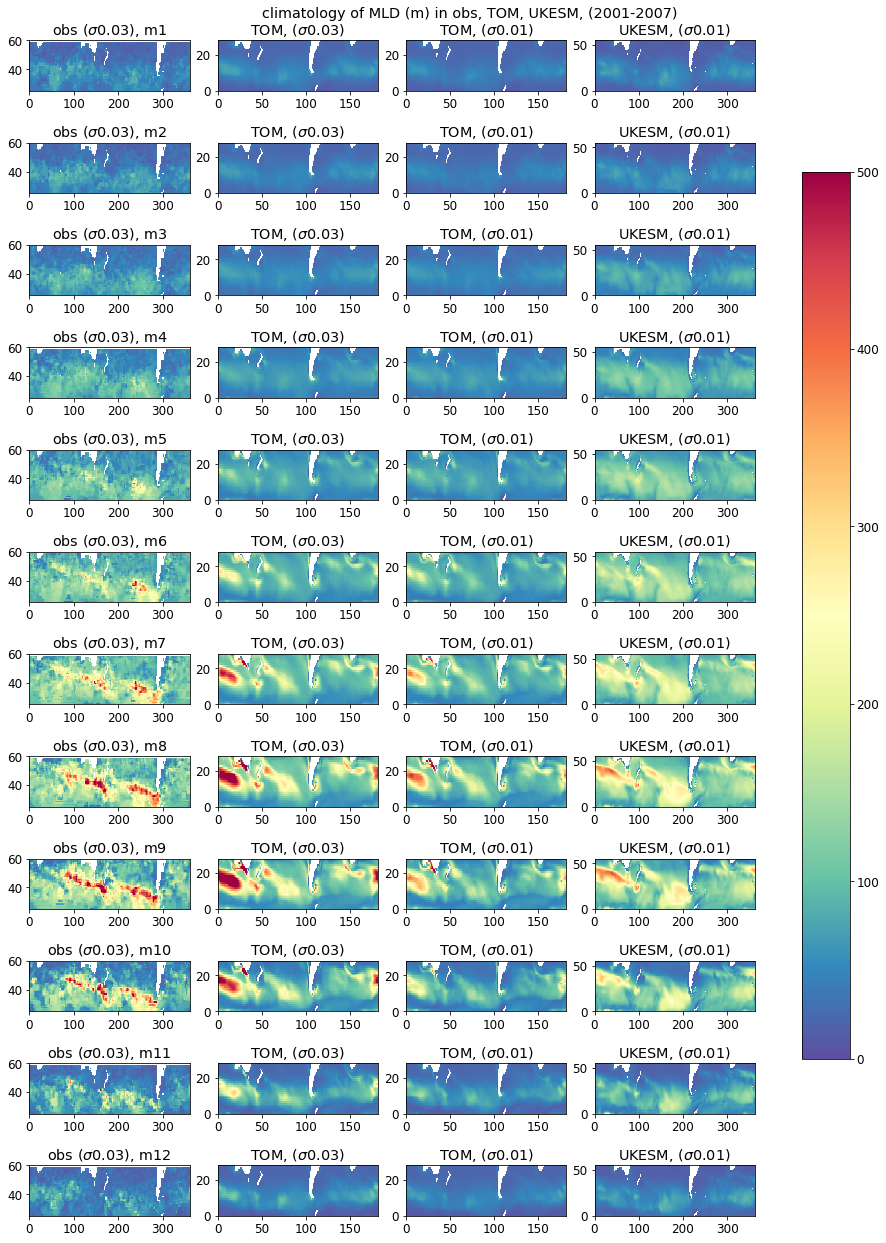

In [91]:
fact = 1.1
fig, axs = plt.subplots(12,4, figsize=(12*fact, 16*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

TJ_1AA6 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50)).values
TJ_1AA6[TJ_1AA6 == 0] = np.nan

TJ_1AA6_01 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,50)).values
TJ_1AA6_01[TJ_1AA6_01 == 0] = np.nan

ukesm_01 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,140)).values

for i in range(0,12):
    q = axs[i*4].pcolormesh(w_masked.MLD[i,:,:], vmin = 0, vmax = 500, cmap = 'Spectral_r')
    axs[i*4].set_ylim([25,60])
    axs[i*4].set_title(f'obs ($\sigma$0.03), m{i+1}')

    q = axs[i*4+1].pcolormesh(TJ_1AA6[i,:,:], vmin = 0, vmax = 500, cmap = 'Spectral_r')
    axs[i*4+1].set_title(f'TOM, ($\sigma$0.03)')

    q = axs[i*4+2].pcolormesh(TJ_1AA6_01[i,:,:], vmin = 0, vmax = 500, cmap = 'Spectral_r')
    axs[i*4+2].set_title(f'TOM, ($\sigma$0.01)')

    q = axs[i*4+3].pcolormesh(ukesm_01[i,:,:], vmin = 0, vmax = 500, cmap = 'Spectral_r')
    axs[i*4+3].set_title(f'UKESM, ($\sigma$0.01)')



plt.suptitle('climatology of MLD (m) in obs, TOM, UKESM, (2001-2007)')
plt.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(q, cax=cbar_ax)

## calculate somxl for ukesm

In [92]:
def make_yearlist(yrst, yrend, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/nemo_scen_1A_1m_{yrs[i]}_fy_grid-T.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_TS'
ylist = make_yearlist(2001,2007,baseDir)



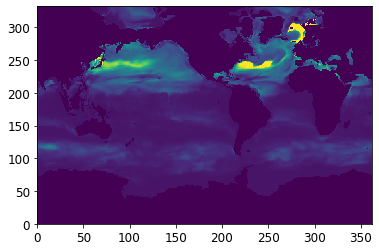

In [93]:
w2 = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_TS/nemo_scen_1A_1m_2001_calcMLD.nc')

plt.pcolormesh(w2.MLD_01[0,:,:], vmin = 0, vmax = 200)


NameError: name 'gsw' is not defined

## example calculation of how to find the different densities

44.112825736990445
89.76907030591894


(-500.0, 0.0)

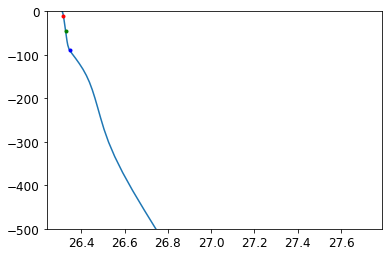

In [99]:
import gsw

w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_TS/nemo_scen_1A_1m_2072_fy_grid-T.nc')
deptht = w.deptht.values

ct = w.thetao[0,:,100,200]
sa = w.so[0,:,100,200]
st = gsw.sigma0(sa,ct)
st = st.values


# def get_mld(sa,ct,deptht):

dens_10m = np.interp(10, deptht[7:9], st[7:9])
dens01 = dens_10m+0.01
dens03 = dens_10m+0.03


fb_01 = [np.where(st >= dens01)][0][0]
fb_01 = fb_01[0]
depth_dens01 = np.interp(dens01,st[fb_01-1:fb_01+1], deptht[fb_01-1:fb_01+1])
print(depth_dens01)
#
fb_03 = [np.where(st >= dens03)][0][0]
fb_03 = fb_03[0]
depth_dens03 = np.interp(dens03,st[fb_03-1:fb_03+1], deptht[fb_03-1:fb_03+1])
print(depth_dens03)

plt.figure()
plt.plot(st,-deptht)
plt.plot(dens_10m,-10,'r.')
plt.plot(dens01,-depth_dens01,'g.')
plt.plot(dens03,-depth_dens03,'b.')
plt.ylim([-500,0])


In [100]:
orig = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_mld/nemo_scen_1A_1m_2001_fy_grid-T.nc')
mod = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_TS/nemo_scen_1A_1m_2001_calcMLD.nc')

orig_010 = orig.somxl010
mod_010 = mod.MLD_01
mod_010 = mod_010.where(mod_010>0, drop=False)
mod_030 = mod.MLD_03
mod_030 = mod_030.where(mod_030>0, drop=False)


## mld backcalc ukesm vs output


In [101]:
def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataArray
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average xarray
    """
    #lest make a copy of the xa
    xa_copy:xr.DataArray = xa.copy()

    if mask is not None:
        xa_weighted_average = __weighted_average_with_mask(
            dim, mask, weights, xa, xa_copy
        )
    elif weights is not None:
        xa_weighted_average = __weighted_average(
            dim, weights, xa, xa_copy
        )
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average



    # %% [markdown]


def __weighted_average(dim, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
    x_times_w = xa_copy * weights_all_dims
    xw_sum = x_times_w.sum(dim)
    x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
    xa_weighted_average = xw_sum / x_tot
    return xa_weighted_average


def __weighted_average_with_mask(dim, mask, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, mask_all_dims = xr.broadcast(xa, mask)  # broadcast to all dims
    xa_copy = xa_copy.where(np.logical_not(mask))
    if weights is not None:
        _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
        weights_all_dims = weights_all_dims.where(~mask_all_dims)
        x_times_w = xa_copy * weights_all_dims
        xw_sum = x_times_w.sum(dim=dim)
        x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
        xa_weighted_average = xw_sum / x_tot
    else:
        xa_weighted_average = xa_copy.mean(dim)
    return xa_weighted_average


# ## Application 1: Weigted global average:
# Grid cells have different area, so when we do the global average, they have to be weigted by the area of each grid cell.
# Here we do it for 2 m temperature:

In [102]:
tds = orig_010[0,:,:]-mod_010[0,:,:]
mm_med = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/mesh_mask_eORCA1_wrk.nc')
mm_med['area'] = mm_med.tmask[0,:,:] * mm_med.e1t[:,:] * mm_med.e2t[:,:]



xa_weighted_average = masked_average(tds, dim=['y','x'], weights=mm_med['area'])

In [103]:
xa_weighted_average

<xarray.DataArray ()>
array(4.99312489)

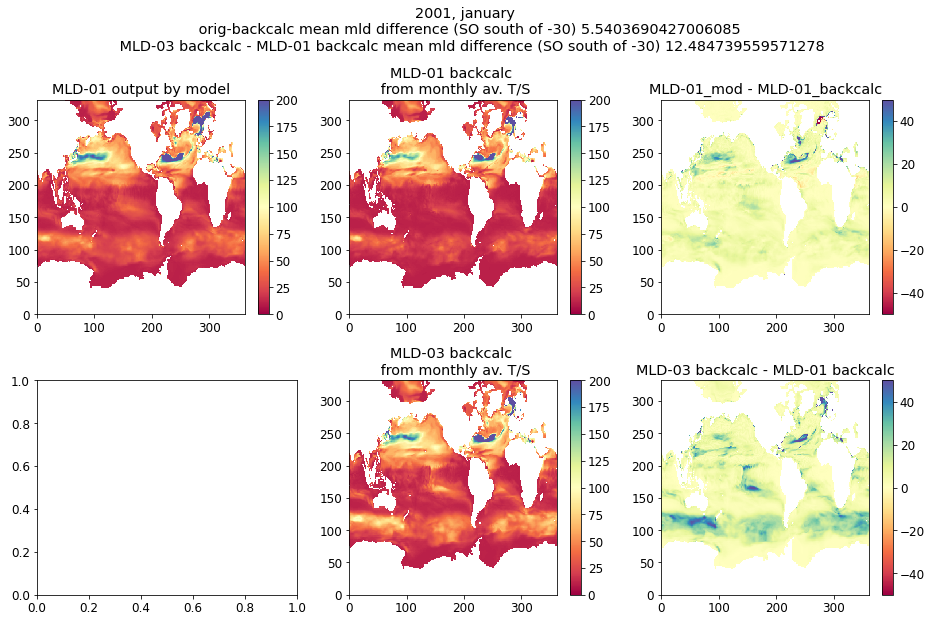

In [107]:
tvm = 200
mo = 0
suptit = '2001, january '
fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolormesh(orig_010[mo,:,:].values, vmin = 0, vmax = tvm, cmap = 'Spectral')
plt.colorbar(w, ax = axs[0])
w = axs[1].pcolormesh(mod_010[mo,:,:].values, vmin = 0, vmax = tvm, cmap = 'Spectral')
plt.colorbar(w, ax = axs[1])
w = axs[2].pcolormesh(orig_010[mo,:,:].values-mod_010[mo,:,:].values, vmin = -50, vmax = 50, cmap = 'Spectral')
plt.colorbar(w, ax = axs[2])

wa = masked_average((orig_010[mo,:,:].isel(y=slice(0,140))-mod_010[mo,:,:].isel(y=slice(0,140))),\
                    dim=['y','x'], weights=mm_med['area'].isel(y=slice(0,140)))
n1 = (f'orig-backcalc mean mld difference (SO south of -30) {wa.values}')


w = axs[4].pcolormesh(mod_030[mo,:,:], vmin = 0, vmax = tvm, cmap = 'Spectral')
plt.colorbar(w, ax = axs[4])
w = axs[5].pcolormesh(mod_030[mo,:,:]-mod_010[mo,:,:], vmin = -50, vmax = 50, cmap = 'Spectral')
plt.colorbar(w, ax = axs[5])
wa = masked_average((mod_030[mo,:,:].isel(y=slice(0,140))-mod_010[mo,:,:].isel(y=slice(0,140))),\
                    dim=['y','x'], weights=mm_med['area'].isel(y=slice(0,140)))

n2 = (f'MLD-03 backcalc - MLD-01 backcalc mean mld difference (SO south of -30) {wa.values}')


tits = ['MLD-01 output by model', 'MLD-01 backcalc \n from monthly av. T/S', 'MLD-01_mod - MLD-01_backcalc',
       '','MLD-03 backcalc \n from monthly av. T/S', 'MLD-03 backcalc - MLD-01 backcalc']
for i in range(0,6):
    axs[i].set_title(tits[i])
plt.suptitle(f'{suptit} \n {n1} \n {n2}')
plt.tight_layout()


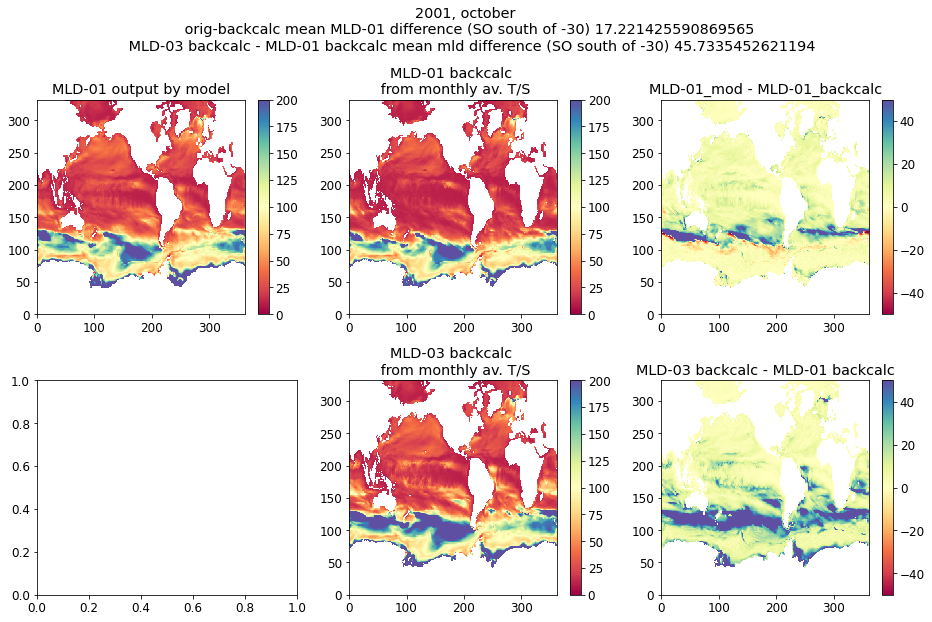

In [111]:
tvm = 200
mo = 9
suptit = '2001, october '
fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolormesh(orig_010[mo,:,:].values, vmin = 0, vmax = tvm, cmap = 'Spectral')
plt.colorbar(w, ax = axs[0])
w = axs[1].pcolormesh(mod_010[mo,:,:].values, vmin = 0, vmax = tvm, cmap = 'Spectral')
plt.colorbar(w, ax = axs[1])
w = axs[2].pcolormesh(orig_010[mo,:,:].values-mod_010[mo,:,:].values, vmin = -50, vmax = 50, cmap = 'Spectral')
plt.colorbar(w, ax = axs[2])

wa = masked_average((orig_010[mo,:,:].isel(y=slice(0,140))-mod_010[mo,:,:].isel(y=slice(0,140))),\
                    dim=['y','x'], weights=mm_med['area'].isel(y=slice(0,140)))
n1 = (f'orig-backcalc mean MLD-01 difference (SO south of -30) {wa.values}')


w = axs[4].pcolormesh(mod_030[mo,:,:], vmin = 0, vmax = tvm, cmap = 'Spectral')
plt.colorbar(w, ax = axs[4])
w = axs[5].pcolormesh(mod_030[mo,:,:]-mod_010[mo,:,:], vmin = -50, vmax = 50, cmap = 'Spectral')
plt.colorbar(w, ax = axs[5])
wa = masked_average((mod_030[mo,:,:].isel(y=slice(0,140))-mod_010[mo,:,:].isel(y=slice(0,140))),\
                    dim=['y','x'], weights=mm_med['area'].isel(y=slice(0,140)))

n2 = (f'MLD-03 backcalc - MLD-01 backcalc mean mld difference (SO south of -30) {wa.values}')


tits = ['MLD-01 output by model', 'MLD-01 backcalc \n from monthly av. T/S', 'MLD-01_mod - MLD-01_backcalc',
       '','MLD-03 backcalc \n from monthly av. T/S', 'MLD-03 backcalc - MLD-01 backcalc']
for i in range(0,6):
    axs[i].set_title(tits[i])
plt.suptitle(f'{suptit} \n {n1} \n {n2}')
plt.tight_layout()


In [154]:
def make_yearlist_mlduk(yrst, yrend):
    yrs = np.arange(yrst,yrend,1)
    ylist = []
    for i in range(0,len(yrs)):
        y = yrs[i]
        tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_gridT_TS/'
        t2 = glob.glob(f'{tdir}/nemo_scen_1A_1m_{y}_calcMLD.nc')
        ylist.append(t2[0])
    return ylist


ukesm_bc = xr.open_mfdataset(make_yearlist_mlduk(2001, 2004))
ukesm_bc = ukesm_bc.where(ukesm_bc>0, drop=False)

In [155]:
TJ_1AA6_50somxl030 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
TJ_1AA6_50mldr10_1 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,37)).weighted(mm_tom.area.sel(y=slice(22,37))).mean(dim = ['y','x'])
ukesm_50somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,114)).weighted(mm_med.area.sel(y=slice(85,114))).mean(dim = ['y','x'])

TJ_1AA6_somxl030 = TJ_1AA6_mld.somxl030.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
TJ_1AA6_mldr10_1 = TJ_1AA6_mld.mldr10_1.groupby('time_counter.month').mean().sel(y = slice(22,50)).weighted(mm_tom.area.sel(y=slice(22,50))).mean(dim = ['y','x'])
ukesm_somxl010 = ukesm_mld.somxl010.groupby('time_counter.month').mean().sel(y = slice(85,140)).weighted(mm_med.area.sel(y=slice(85,140))).mean(dim = ['y','x'])

ukesm_bc_somxl010 = ukesm_bc.MLD_01.groupby('time_counter.month').mean().sel(y = slice(85,140)).weighted(mm_med.area.sel(y=slice(85,140))).mean(dim = ['y','x'])
ukesm_bc_somxl030 = ukesm_bc.MLD_03.groupby('time_counter.month').mean().sel(y = slice(85,140)).weighted(mm_med.area.sel(y=slice(85,140))).mean(dim = ['y','x'])

ukesm_bc_50somxl010 = ukesm_bc.MLD_01.groupby('time_counter.month').mean().sel(y = slice(85,114)).weighted(mm_med.area.sel(y=slice(85,114))).mean(dim = ['y','x'])
ukesm_bc_50somxl030 = ukesm_bc.MLD_03.groupby('time_counter.month').mean().sel(y = slice(85,114)).weighted(mm_med.area.sel(y=slice(85,114))).mean(dim = ['y','x'])


In [ ]:
#ET_SI73_mld/mldr10_1
#-64.867195 to #-30.455408
mos = np.arange(1,13,1)
fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(5*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(mos, mld_DONG, color = 'k', linestyle = '-', linewidth = 3.5, label = 'Dong 2008 obs. \n 0.03 crit')
axs[1].plot(mos, mld_50DONG, color = 'k', linestyle = '-', linewidth = 3.5, label = 'Dong 2008 obs. \n 0.03 crit')

axs[0].plot(mos,ukesm_bc_somxl030, color = 'r',linestyle = '-', linewidth = 3, \
 label = 'UKESM (backcalc) \n 0.03 crit')
axs[0].plot(mos,ukesm_bc_somxl010, color = 'r',linestyle = '--', linewidth = 2, \
 label = 'UKESM (backcalc) \n 0.01 crit')
axs[0].plot(mos,ukesm_somxl010, color = 'r',linestyle = ':', linewidth = 2, \
 label = 'UKESM (output) \n 0.01 crit')


axs[0].plot(mos,TJ_1AA6_mldr10_1, color = 'b',linestyle = ':', linewidth = 2, \
 label = 'TOMA6 (output) \n 0.01 crit')
axs[0].plot(mos,TJ_1AA6_somxl030, color = 'b',linestyle = '-', linewidth = 3, \
 label = 'TOMA6 (output) \n 0.03 crit')

###
axs[1].plot(mos,ukesm_bc_50somxl030, color = 'r',linestyle = '-', linewidth = 3, \
 label = 'UKESM (backcalc) \n 0.03 crit')
axs[1].plot(mos,ukesm_bc_50somxl010, color = 'r',linestyle = '--', linewidth = 2, \
 label = 'UKESM (backcalc) \n 0.01 crit')
axs[1].plot(mos,ukesm_50somxl010, color = 'r',linestyle = ':', linewidth = 2, \
 label = 'UKESM (output) \n 0.01 crit')


axs[1].plot(mos,TJ_1AA6_50mldr10_1, color = 'b',linestyle = ':', linewidth = 2, \
 label = 'TOMA6 (output) \n 0.01 crit')
axs[1].plot(mos,TJ_1AA6_50somxl030, color = 'b',linestyle = '-', linewidth = 3, \
 label = 'TOMA6 (output) \n 0.03 crit')

axs[0].legend(bbox_to_anchor = [1,1])

for i in range(0,2):
    axs[i].set_xlim([1,12])
    axs[i].set_ylim([20,190])
    axs[i].grid(alpha = 0.3)

axs[0].set_title('MLD climatology (2001-2007), south of -30')
axs[1].set_title('MLD climatology (2001-2007), south of -50')